# imports

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import numpy.ma as ma
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel
import tensorflow as tf
from torch import no_grad
from keras import Sequential, layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical # for target labels

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

Using TensorFlow backend.


# Feature Mappings

In [2]:
# load data
df = pd.read_csv('data/train.csv')

# drop 213 impossible reputation rows < 1
df = df.loc[df.ReputationAtPostCreation > 0]

# Create no_reputation feature indicating no recognized activity
df['no_reputation'] = df.ReputationAtPostCreation.map(lambda x: int(x == 1))

# log transform ReputationAtPostCreation and OwnerUndeletedAnswerCountAtPostTime
df['ReputationAtPostCreation'] = df.ReputationAtPostCreation.map(lambda x: np.log(x))
df['OwnerUndeletedAnswerCountAtPostTime'] = df.OwnerUndeletedAnswerCountAtPostTime.map(lambda x: np.log(x+1))

# Create account_age feature and drop negative ages
df[['PostCreationDate','OwnerCreationDate']] = df[['PostCreationDate','OwnerCreationDate']].apply(pd.to_datetime)
df['account_age'] = (df['PostCreationDate'] - df['OwnerCreationDate']).dt.days
df = df.loc[df.account_age >= 0]

df.reset_index(drop=True, inplace=True)

# Create Text feature (joining tags, title and body text)
mask = df[['Tag1','Tag2','Tag3','Tag4','Tag5','Title','BodyMarkdown']].isna()
tag_values = ma.masked_array(df[['Tag1','Tag2','Tag3','Tag4','Tag5','Title','BodyMarkdown']], mask=mask)
df['text'] = [". ".join(row_tags.compressed()) for row_tags in tag_values]

# Create title and body word count features
df['title_wc'] = df.Title.map(lambda x: len(x.split()))
df['body_wc'] = df.BodyMarkdown.map(lambda x: len(x.split()))

# Create num_tags feature, counting how many tags are used
df['num_tags'] = df[['Tag1','Tag2','Tag3','Tag4','Tag5']].transpose().notna().sum()

# Create word embedding features from Text
embedding_magnitude = 768
display('shape before dropping long texts:',df.shape)
embeddings = np.zeros((df.shape[0], embedding_magnitude))

tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")
model = AutoModel.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")

# df['text_wc'] = df.text.map(lambda x: len(x))
# ishapes = [tokenizer(text, return_tensors="pt")['input_ids'].shape[1] for text in df.text]
# df['ishapes'] = ishapes
# fig, ax = plt.subplots(figsize=(10,10))
# sns.lineplot(df[['text_wc','ishapes']],ax=ax)

with no_grad():
    for i, text in enumerate(df.text):
        # print status
        if i%100 == 0:
            print(i,"/",df.shape[0])

        # get tokens
        inputs = tokenizer(text, return_tensors="pt")

        # nan rows with too many tokens
        if inputs['input_ids'].shape[1] > 512:
            embeddings[i,:] = np.array([np.nan]*embedding_magnitude)
            continue
        out = model(**inputs)['pooler_output']
        embeddings[i,:] = np.array(out)

use_cols = ['OpenStatus',
            'ReputationAtPostCreation',
            'OwnerUndeletedAnswerCountAtPostTime',
            'account_age',
            'num_tags',
            'title_wc',
            'body_wc']
df = pd.concat((df[use_cols],pd.DataFrame(embeddings,columns=[f"emb_{i}" for i in range(embedding_magnitude)])), axis=1).dropna()
df.reset_index(drop=True, inplace=True)


KeyboardInterrupt: 

# Save to CSV

In [4]:
df.to_csv('/data/text_embeddings_v2.csv')

NameError: ignored

# Model Pipeline

In [120]:
df = pd.read_csv('drive/MyDrive/nlp_project/data/text_embeddings.csv', index_col=0)
df = df.reset_index(drop=True)
df['no_reputation'] = df.ReputationAtPostCreation.map(lambda x: int(x == 1))
df['ReputationAtPostCreation'] = PowerTransformer().fit_transform(df[['ReputationAtPostCreation']])
df['account_age'] = PowerTransformer().fit_transform(df[['account_age']])
df['OwnerUndeletedAnswerCountAtPostTime'] = df['OwnerUndeletedAnswerCountAtPostTime'].map(lambda x: np.exp(x) - 1)
df['no_contributions'] = df['OwnerUndeletedAnswerCountAtPostTime'].map(lambda x: int(x==0))
df['OwnerUndeletedAnswerCountAtPostTime'] = PowerTransformer().fit_transform(df[['OwnerUndeletedAnswerCountAtPostTime']])
status_id_map = {'open':0, 'not a real question':1,'off topic':2,'not constructive':3,'too localized':4,
                 0:'open', 1:'not a real question',2:'off topic',3:'not constructive',4:'too localized'}
df.OpenStatus = df.OpenStatus.map(status_id_map)
df = df[['num_tags', 'title_wc','body_wc'] + df.drop(columns=['num_tags', 'title_wc','body_wc']).columns.to_list()].astype(np.float32)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['OpenStatus']), df.OpenStatus, test_size=0.2, random_state=42)
X_train, X_test, y_train = X_train.values, X_test.values, to_categorical(y_train)

scale_cols = [0,1,2] # ['num_tags', 'title_wc','body_wc']


# Keras Model
class KerasTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model, batch_size=128, epochs=100):
        self.model = model
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y=None):
        trainCallback = EarlyStopping(monitor='loss', min_delta = 1e-6, patience = 5)
        self.model.fit(X, 
                       y, 
                       batch_size=self.batch_size, 
                       epochs=self.epochs, 
                       verbose=2, 
                       validation_split = 0.2, 
                       callbacks=[trainCallback])
        return self

    def transform(self, X):
        return self.model.predict(X)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

    def predict(self, X):
        return self.model.predict(X)

# Define the Keras sequential model
model = Sequential([
    layers.Dense(256, activation='relu', input_shape=(776,), kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(.001)),
    layers.Dropout(.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.001)),
    layers.Dropout(.5),
    layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the preprocessing pipeline with KerasTransformer
preprocessor = ColumnTransformer([('scaler', StandardScaler(), scale_cols)], remainder='passthrough')
pipeline_model = Pipeline([('preprocessor', preprocessor), ('model', KerasTransformer(model))])

model.summary()
# Fit the pipeline and model to the training data
pipeline_model.fit(X_train, y_train)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 256)               198912    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_81 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_82 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_83 (Dense)            (None, 5)               

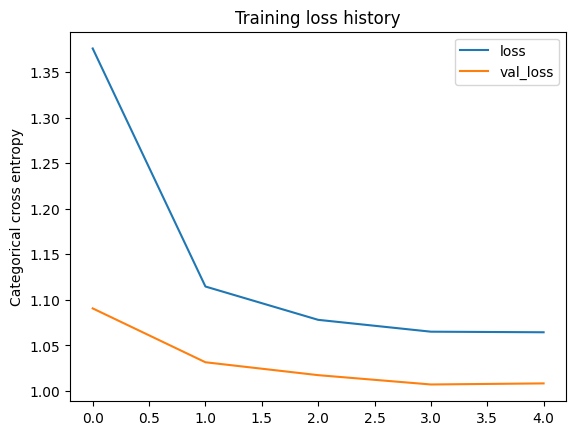

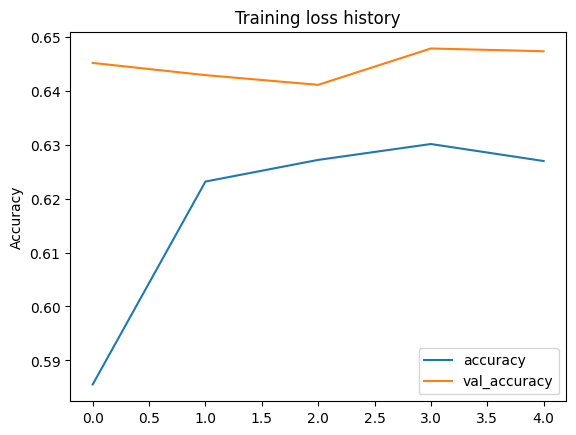

759/759 [==============================] - 5s 6ms/step


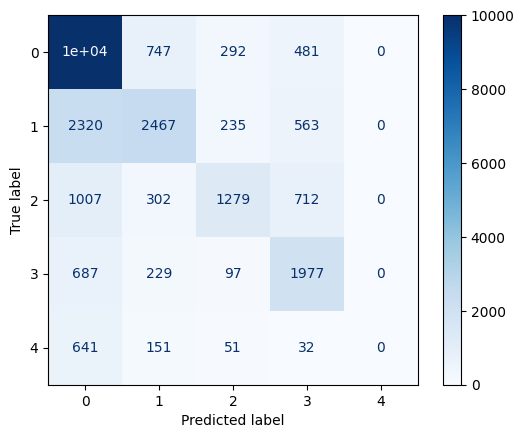

In [167]:
history = pd.DataFrame(pipeline_model['model'].model.history.history)
col_list = ['loss', 'val_loss']
history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

col_list = ['accuracy', 'val_accuracy']
history[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

# probability for each class
y_proba = pipeline_model.predict(X_test)
predicted = np.argmax(y_proba, axis=-1)

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()